In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import lightning.pytorch as pl
import torch
from matplotlib import pyplot as plt
import numpy as np
import pickle
from itertools import product
from skimage.morphology import disk, remove_small_objects
from skimage.measure import label, regionprops
from tqdm import tqdm
import pandas as pd 
from collections import defaultdict


sys.path.insert(1, sys.path[0] + '/..')
from src.data.datamodule import DataModule
from src.data.utils import simplify_labels
from src.model.setup import setup_model
from src.misc.utils import set_seed_and_precision
from src.misc.files import SetupArgs, read_image
from src.misc.post import calculate_metrics
from src.postprocess import _remove_low_probs, _remove_spine_fp, _remove_small_objects, _post_process
from src.postprocess import main as postprocess_main, parse_option as postprocess_parse_option

from src.run import parse_option, main
args = parse_option(notebook=True)
args.data_dir = '../data_dev'
args.version = 'version_sam'
args.num_workers = 8

Train

In [2]:
# args.train, args.predict = True, False
# args.splits = ['train', 'val']
# main(args)

Predict with custom loading

In [3]:
# setup_args = SetupArgs(**{
#     'net' : 'unet3d',
#     'predict' : True,
#     'train' : False,
#     'log_dir' : '../logs',
#     'version' : 'version_sam',
# })

# trained_unet = setup_model(setup_args)

In [4]:
# x = torch.randn(1, 32, 32, 32) # a random image
# y = torch.tensor([-1]) # a random label
# batch = (x, y)
# trained_unet(batch)

Predict directly in run

In [5]:
args.train, args.predict = False, True
args.splits = ['val']
main(args)

Global seed set to 42
/Users/elias/anaconda3/envs/ribfrac/lib/python3.8/site-packages/lightning/pytorch/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.9.post0, which is newer than your current Lightning version: v2.0.9
  rank_zero_warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/elias/anaconda3/envs/ribfrac/lib/python3.8/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Post process

In [6]:
postprocess_args = postprocess_parse_option(notebook=True)
postprocess_args.split = 'val'
postprocess_args.prediction_box_dir = os.path.join(args.log_dir, args.net, args.version, 'segmentations')
postprocess_args.original_image_dir = args.data_dir
postprocess_args.save_dir = os.path.join(args.log_dir, 'submissions', args.version, postprocess_args.split)

postprocess_args.prob_threshold = 0.1
postprocess_args.size_thresh = 100

postprocess_main(postprocess_args)

100%|██████████| 2/2 [00:09<00:00,  4.84s/it]


In [13]:
device = 'cpu'

l = 10
ranges = {
    'prob_thresh' : np.linspace(0, 1, l),
    'bone_thresh' : np.array([200]),
    'size_thresh' : np.linspace(0, 2000, l)
}

img_ids = os.listdir(os.path.join(postprocess_args.prediction_box_dir, postprocess_args.split))
combis = list(product(*ranges.values()))
gs = pd.DataFrame(columns = ranges.keys(), data = combis)

for metric in ['accuracy', 'precision', 'recall']:
    gs[metric] = [[] for _ in range(len(gs))]

for img_id in img_ids:
    x, _ = read_image(os.path.join(postprocess_args.original_image_dir, 'raw', postprocess_args.split, 'images', f'{img_id}-image.nii.gz'))
    y_pred = np.load(os.path.join(postprocess_args.save_dir, f'{img_id}_pred.npy'))
    y_true, _ = read_image(os.path.join(postprocess_args.original_image_dir, 'raw', postprocess_args.split, 'labels', f'{img_id}-label.nii.gz'))
    y_true = torch.tensor(simplify_labels(y_true), device = device, dtype = torch.int)
    
    for i, combi in tqdm(gs.iterrows(), total=len(gs)):
        prob_thresh, bone_thresh, size_thresh = combi[:3]

        y_pred_post = _post_process(pred = y_pred, image = x, prob_thresh=prob_thresh, bone_thresh=bone_thresh, size_thresh=size_thresh)
        y_pred_post = torch.tensor(simplify_labels(y_pred_post), device = device, dtype = torch.int)
        
        metric = calculate_metrics(y_true, y_pred_post)
        
        for k, v in metric.items():
            gs.loc[i, k].append(v)


gs['accuracy_mean'] = gs['accuracy'].apply(lambda x: np.mean(x))
gs['precision_mean'] = gs['precision'].apply(lambda x: np.mean(x))
gs['recall_mean'] = gs['recall'].apply(lambda x: np.mean(x))
gs['accuracy_std'] = gs['accuracy'].apply(lambda x: np.std(x))
gs['precision_std'] = gs['precision'].apply(lambda x: np.std(x))
gs['recall_std'] = gs['recall'].apply(lambda x: np.std(x))

gs.to_csv('../store/grid_search.csv')

gs

 17%|█▋        | 17/100 [00:43<03:32,  2.56s/it]


KeyboardInterrupt: 

Analysis

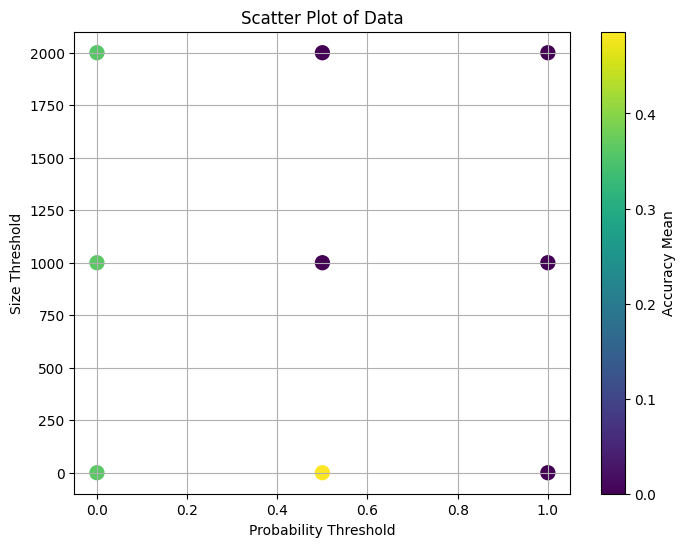

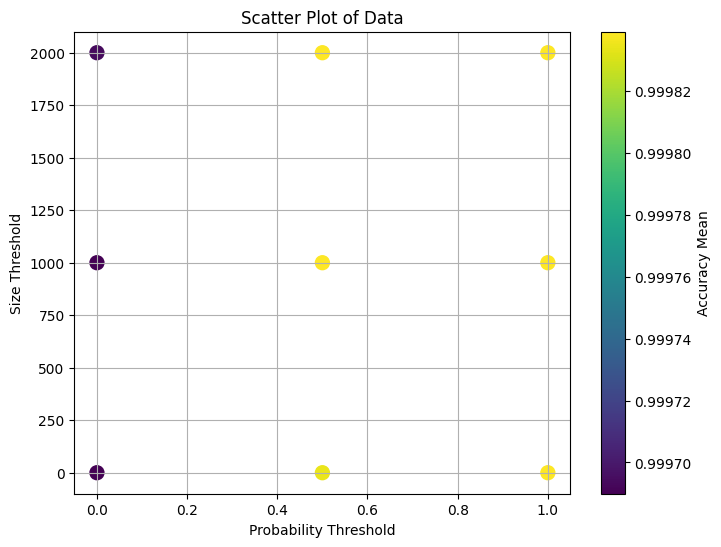

In [ ]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(gs['prob_thresh'], gs['size_thresh'], c=gs['precision_mean'], cmap='viridis', s=100)
plt.colorbar(label='Accuracy Mean')
plt.xlabel('Probability Threshold')
plt.ylabel('Size Threshold')
plt.title('Scatter Plot of Data')
plt.grid(True)

plt.show()

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(gs['prob_thresh'], gs['size_thresh'], c=gs['accuracy_mean'], cmap='viridis', s=100)
plt.colorbar(label='Accuracy Mean')
plt.xlabel('Probability Threshold')
plt.ylabel('Size Threshold')
plt.title('Scatter Plot of Data')
plt.grid(True)

plt.show()